#VAE Implementation for Image Generation:

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set device for computation (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Load the MNIST dataset with basic transformations
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [9]:
# Step 1: Define the VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()

        # Encoder Layers
        self.fc1 = nn.Linear(784, 400)  # Input layer to hidden layer
        self.fc21 = nn.Linear(400, latent_dim)  # Hidden layer to mean vector
        self.fc22 = nn.Linear(400, latent_dim)  # Hidden layer to log variance vector

        # Decoder Layers
        self.fc3 = nn.Linear(latent_dim, 400)  # Latent space to hidden layer
        self.fc4 = nn.Linear(400, 784)  # Hidden layer to output layer

    def encode(self, x):
        # Encoder forward pass: maps the input to mean and log variance
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        # Reparameterization trick: allows backpropagation through stochastic sampling
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random noise
        return mu + eps * std  # Sampled latent vector

    def decode(self, z):
        # Decoder forward pass: maps the latent vector back to the original input space
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        # Full VAE forward pass: goes through encoder, reparameterization, and decoder
        mu, logvar = self.encode(x.view(-1, 784))  # Encode input to latent space
        z = self.reparameterize(mu, logvar)  # Sample latent vector
        return self.decode(z), mu, logvar  # Decode to reconstruct image

In [10]:
# Instantiate the model, define optimizer
latent_dim = 20
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Step 2: Define the Loss Function
def loss_function(recon_x, x, mu, logvar):
    # Binary Cross-Entropy for reconstruction loss
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL Divergence for regularization (encourages a normal distribution in latent space)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Return combined loss, plus separate BCE and KLD for tracking
    return BCE + KLD, BCE, KLD

In [11]:
# Step 3: Training the VAE
epochs = 10
elbo_losses, bce_losses, kld_losses = [], [], []  # To store loss values for visualization
for epoch in range(epochs):
    model.train()  # Set model to training mode
    train_loss, bce_loss, kld_loss = 0, 0, 0  # Reset epoch losses

    # Loop through batches of data
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # Move data to device
        optimizer.zero_grad()  # Zero gradients

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Compute loss
        loss, bce, kld = loss_function(recon_batch, data, mu, logvar)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Aggregate losses for reporting
        train_loss += loss.item()
        bce_loss += bce.item()
        kld_loss += kld.item()

    # Calculate average losses for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_bce = bce_loss / len(train_loader.dataset)
    avg_kld = kld_loss / len(train_loader.dataset)

    # Store losses for plotting
    elbo_losses.append(avg_loss)
    bce_losses.append(avg_bce)
    kld_losses.append(avg_kld)

    print(f"Epoch {epoch + 1}/{epochs}, ELBO Loss: {avg_loss:.4f}, BCE: {avg_bce:.4f}, KLD: {avg_kld:.4f}")

Epoch 1/10, ELBO Loss: 164.7974, BCE: 149.3466, KLD: 15.4508
Epoch 2/10, ELBO Loss: 121.7471, BCE: 99.7679, KLD: 21.9791
Epoch 3/10, ELBO Loss: 114.7368, BCE: 90.9318, KLD: 23.8050
Epoch 4/10, ELBO Loss: 111.6383, BCE: 87.1452, KLD: 24.4931
Epoch 5/10, ELBO Loss: 109.9566, BCE: 85.1152, KLD: 24.8414
Epoch 6/10, ELBO Loss: 108.7557, BCE: 83.7358, KLD: 25.0199
Epoch 7/10, ELBO Loss: 107.9148, BCE: 82.7556, KLD: 25.1591
Epoch 8/10, ELBO Loss: 107.2745, BCE: 82.0300, KLD: 25.2445
Epoch 9/10, ELBO Loss: 106.7791, BCE: 81.4481, KLD: 25.3310
Epoch 10/10, ELBO Loss: 106.3207, BCE: 80.9544, KLD: 25.3663


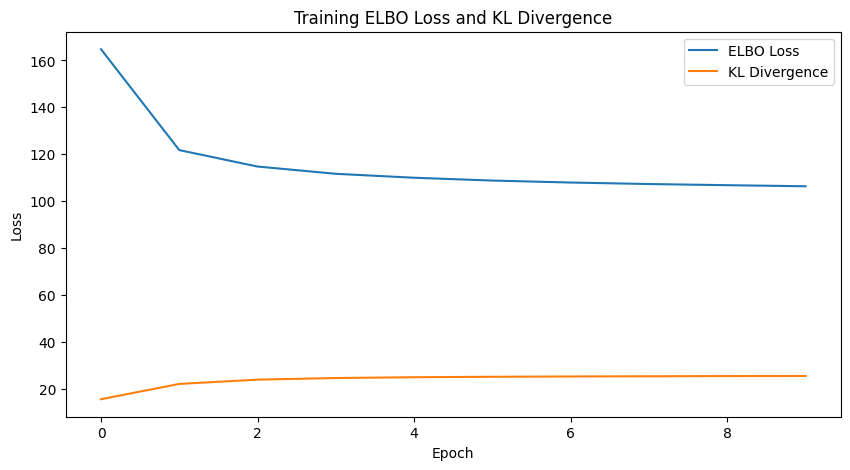

In [12]:
# Step 4: Plot ELBO Loss and KL Divergence
plt.figure(figsize=(10, 5))
plt.plot(elbo_losses, label='ELBO Loss')
plt.plot(kld_losses, label='KL Divergence')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training ELBO Loss and KL Divergence")
plt.show()

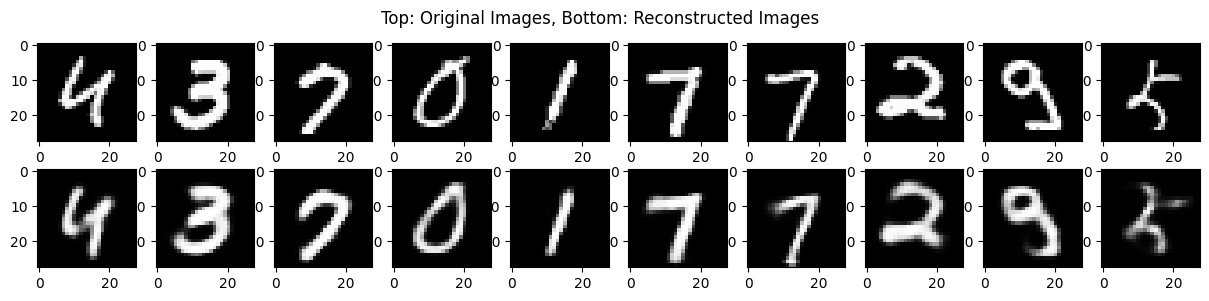

In [13]:
# Step 5a: Visualize Reconstructed Images
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Get a batch of original images
    data, _ = next(iter(train_loader))
    data = data.to(device)

    # Reconstruct images
    recon, _, _ = model(data)

    # Plot original and reconstructed images
    fig, axs = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axs[0, i].imshow(data[i].cpu().view(28, 28), cmap='gray')
        axs[1, i].imshow(recon[i].cpu().view(28, 28), cmap='gray')
    plt.suptitle("Top: Original Images, Bottom: Reconstructed Images")
    plt.show()

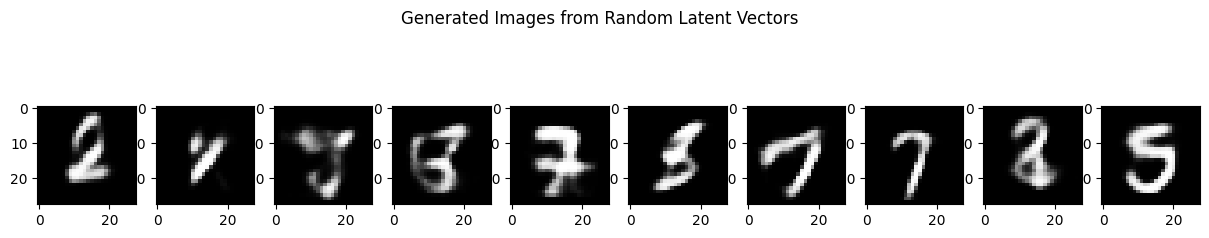

In [14]:
# Step 5b: Generate New Images by Sampling from Latent Space
with torch.no_grad():
    # Sample random points in latent space and decode them
    sample = torch.randn(10, latent_dim).to(device)  # Random latent vectors
    generated = model.decode(sample)  # Decode to generate images

    # Plot generated images
    fig, axs = plt.subplots(1, 10, figsize=(15, 3))
    for i in range(10):
        axs[i].imshow(generated[i].cpu().view(28, 28), cmap='gray')
    plt.suptitle("Generated Images from Random Latent Vectors")
    plt.show()

#VAE for Anomaly Detection

In [15]:
# Function to compute reconstruction error for anomaly detection
def compute_reconstruction_error(data, model):
    recon_data, _, _ = model(data)
    # Calculate mean squared error per image
    return torch.mean((data.view(-1, 784) - recon_data) ** 2, dim=1)

# Function to add noise to create anomalous images
def add_noise(data, noise_factor=0.5):
    # Add random noise to the images
    noisy_data = data + noise_factor * torch.randn(*data.shape).to(device)
    noisy_data = torch.clip(noisy_data, 0., 1.)  # Ensure values remain in the valid range [0, 1]
    return noisy_data

In [16]:
# Step 1: Calculate Reconstruction Errors for Normal and Anomalous Images
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Select a batch of normal images
    normal_data, _ = next(iter(train_loader))
    normal_data = normal_data.to(device)

    # Add noise to create anomalous images
    anomalous_data = add_noise(normal_data)

    # Compute reconstruction errors for both normal and anomalous images
    normal_errors = compute_reconstruction_error(normal_data, model).cpu().numpy()
    anomalous_errors = compute_reconstruction_error(anomalous_data, model).cpu().numpy()

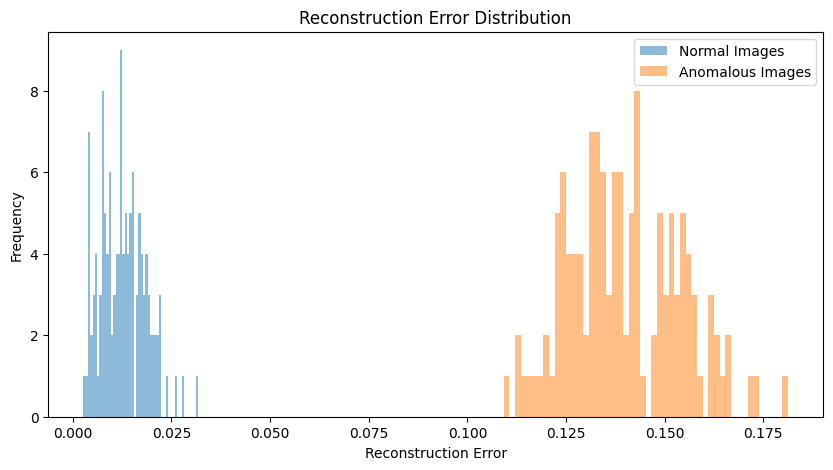

In [17]:
# Step 2: Plot the Distribution of Reconstruction Errors
plt.figure(figsize=(10, 5))
plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal Images')
plt.hist(anomalous_errors, bins=50, alpha=0.5, label='Anomalous Images')
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.title("Reconstruction Error Distribution")
plt.show()

In [18]:
import numpy as np

# Step 3: Set Threshold and Classify Images as Normal or Anomalous
threshold = np.mean(normal_errors) + 3 * np.std(normal_errors)  # Set threshold at 3 standard deviations
print(f"Anomaly Detection Threshold: {threshold:.4f}")

# Example classification based on the threshold
normal_classifications = normal_errors > threshold  # Should mostly be False
anomalous_classifications = anomalous_errors > threshold  # Should mostly be True
normal_anomalies = np.sum(normal_classifications)
anomalous_anomalies = np.sum(anomalous_classifications)

print(f"False Positives (Normal images classified as Anomalous): {normal_anomalies}")
print(f"True Positives (Anomalous images classified as Anomalous): {anomalous_anomalies}")

Anomaly Detection Threshold: 0.0297
False Positives (Normal images classified as Anomalous): 1
True Positives (Anomalous images classified as Anomalous): 128


#VAE Latent Space Visualization

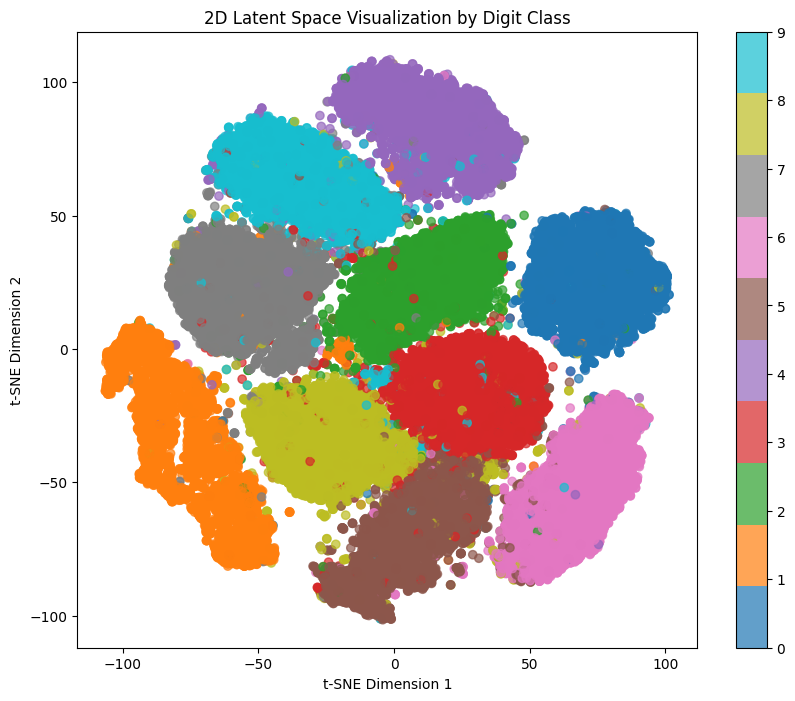

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Step 1: Obtain Latent Representations of Test Images
latent_vectors, labels = [], []
with torch.no_grad():
    for data, label in train_loader:  # Use a batch of data to reduce computation
        data = data.to(device)
        mu, _ = model.encode(data.view(-1, 784))  # Obtain mean (mu) as latent representation
        latent_vectors.append(mu.cpu().numpy())
        labels.append(label.numpy())

# Concatenate all latent vectors and labels for the entire test dataset
latent_vectors = np.concatenate(latent_vectors)
labels = np.concatenate(labels)

# Step 2: Reduce to 2D with t-SNE for Visualization
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

# Step 3: Plot the 2D Latent Space with Colors for Each Digit Class
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("2D Latent Space Visualization by Digit Class")
plt.show()